In [2]:
%matplotlib inline


# Importing dependencies
#*******************************************
import matplotlib
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime as dt
from sqlalchemy import inspect






# Reflect Tables into SQLAlchemy ORM

In [3]:


# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
inspector = inspect(engine)
inspector

In [10]:
# Use inspector to view table details
for tab_name in inspector.get_table_names():
    for column in inspector.get_columns(tab_name):
        print( tab_name,": ", column.get('name'), ", ", column.get('type'))

measurement :  id ,  INTEGER
measurement :  station ,  TEXT
measurement :  date ,  TEXT
measurement :  prcp ,  FLOAT
measurement :  tobs ,  FLOAT
station :  id ,  INTEGER
station :  station ,  TEXT
station :  name ,  TEXT
station :  latitude ,  FLOAT
station :  longitude ,  FLOAT
station :  elevation ,  FLOAT


# Exploratory Climate Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Calculate the date 1 year ago from today
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data

prcp_df = pd.read_sql("SELECT date, prcp FROM measurement", con=engine, columns=[["date"],["prcp"]])



In [12]:
# Converting the "date" field into the date data-type
prcp_df["date"] = pd.to_datetime(prcp_df["date"],format="%Y-%m-%d", errors="coerce")

In [13]:
# Determining the max date and subtracting 365 days to create the minimum date (or the past 12 months)
pa_max_date = prcp_df["date"].max().date()
pa_today = pd.Timestamp(dt.date.today())
pa_min_date = (pa_max_date - dt.timedelta(days=365))
print("Date Range: "+str(pa_min_date)+" to "+str(pa_max_date))

Date Range: 2016-08-23 to 2017-08-23


In [14]:
# Dropping all records from Precipitation Analysis dataframe that are not within the last 12 months from the max date
prcp_df = prcp_df.loc[prcp_df["date"]>=pa_min_date]

C:\Users\smenon\newfolder\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  


In [15]:

prcp_df.set_index("date", inplace=True)
prcp_df.describe(include="all")

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


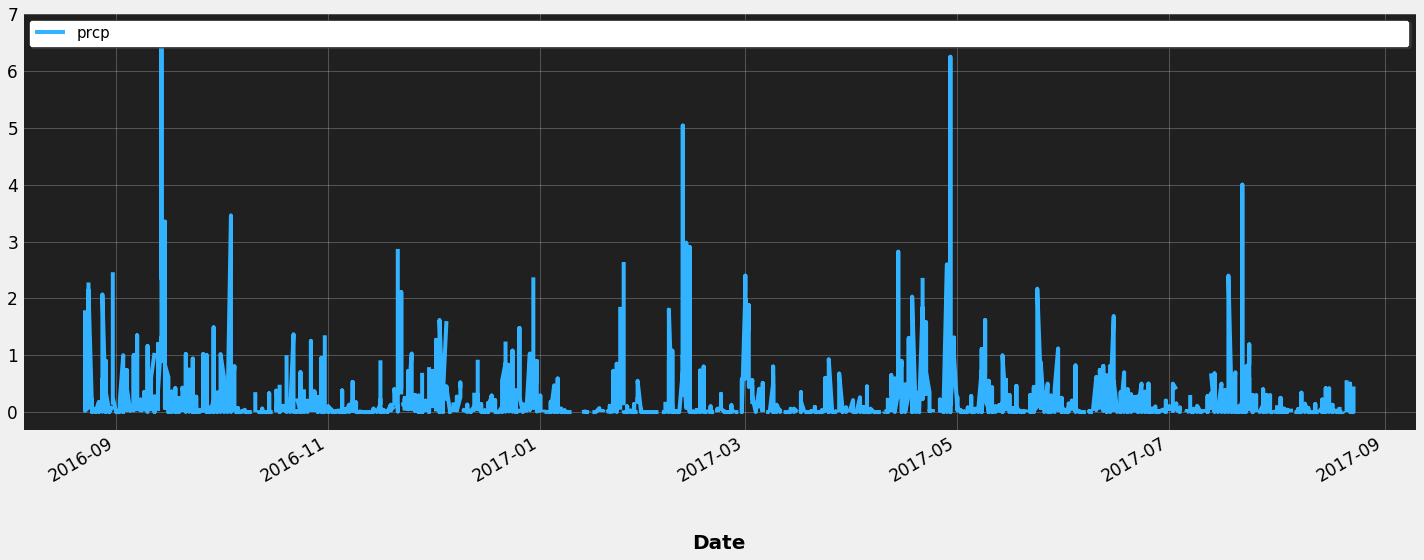

In [16]:

ax = prcp_df.plot.line(y="prcp",figsize=(20,8), fontsize=17, color="#33B3FF")
ax.patch.set_facecolor("#000000")
ax.set_xlabel(xlabel="\n\nDate", fontsize=20, color="#000000", fontweight="bold")
ax.set_frame_on(b=True)
ax.set_facecolor("#202020")
ax.grid(True, alpha=.3)
ax.legend(frameon=True, fancybox=True, facecolor="#FFFFFF", edgecolor="#000000", shadow=True, loc="best", fontsize=15, mode="expand")
ax.label_outer()
plt.tight_layout()
plt.savefig("12Month_prcp_analysis.png")

In [25]:
    prcp_df = pd.read_sql("SELECT date, prcp FROM measurement", con=engine, columns=[["date"],["prcp"]])
    prcp_df["date"] = pd.to_datetime(prcp_df["date"],format="%Y-%m-%d", errors="coerce")
    pa_max_date = prcp_df["date"].max().date()
    pa_today = pd.Timestamp(dt.date.today())
    pa_min_date = (pa_max_date - dt.timedelta(days=365))
    prcp_df = prcp_df.loc[prcp_df["date"]>=pa_min_date]
    prcp_df.set_index("date", inplace=True)
    precip_dict=dict(prcp_df)

C:\Users\smenon\newfolder\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  


In [17]:
# Design a query to show how many stations are available in this dataset?
station_df = pd.read_sql("SELECT s.station, count(m.station) as station_count FROM measurement m,station s WHERE m.station=s.station GROUP BY m.station", con=engine, columns=[["station"],["station_count"]])


In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_df.sort_values(by="station_count", ascending=False, inplace=True)
indexed_station = station_df.set_index("station")
indexed_station

,station_count
station,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station = indexed_station.station_count.max()
most_active = list(np.where(indexed_station["station_count"]==most_active_station)[0])
station_max = indexed_station.iloc[most_active]
station_max =str(station_max.index[0])
print("Station with the most observations recorded: "+station_max+
      ", with a count of {:,} observations".format(most_active_station))

Station with the most observations recorded: USC00519281, with a count of 2,772 observations


In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
st_results = session.query(Measurement.date,Measurement.tobs).\
            filter(Measurement.date >= pa_min_date).\
            filter(Measurement.station==station_max).all()

In [21]:

# Converting the results of the query into a pandas dataframe
sh_max_df = pd.DataFrame(np.array(st_results), columns=(["date","tobs"]))
sh_max_df

,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0
5,2016-08-28,73.0
6,2016-08-29,78.0
7,2016-08-30,77.0
8,2016-08-31,78.0
9,2016-09-01,80.0


In [22]:
# Converting the data types so that the "tobs" column will return a value
sh_max_df.tobs = sh_max_df.tobs.astype(float)

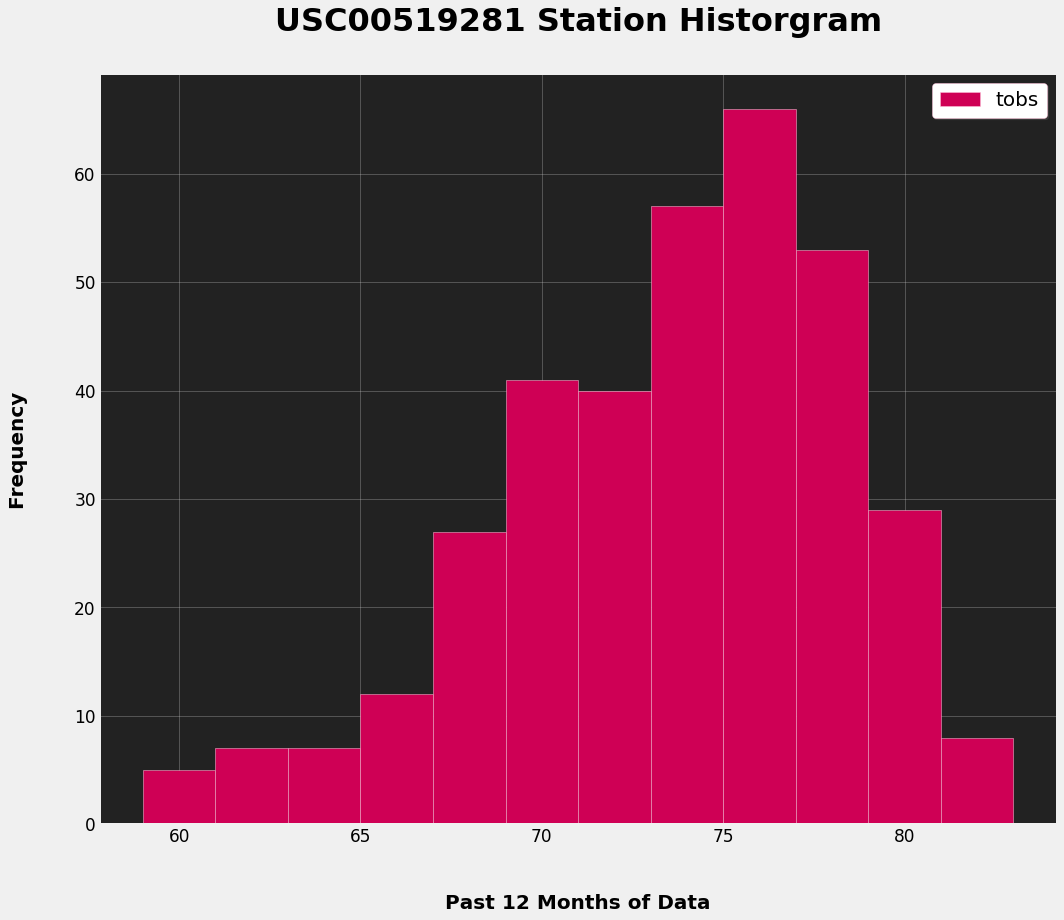

In [23]:
ax = sh_max_df.plot.hist(by=None, bins=12, figsize=(15, 13), color="#CF0055", fontsize=17, edgecolor="#FFC1DA")
ax.set_xlabel(xlabel="\n\nPast 12 Months of Data", fontsize=20, color="#000000", fontweight="bold")
ax.set_frame_on(b=True)
ax.set_facecolor("#222222")
ax.grid(True, alpha=.3)
ax.set_ylabel(ylabel="Frequency\n\n", fontsize=20,fontweight="bold")
ax.legend(frameon=True, fancybox=True, facecolor="#FFFFFF", edgecolor="#FFC1DA", shadow=True, loc="best", fontsize=20, mode="exapnd")
ax.label_outer()
ax.set_title(str(station_max+" Station Historgram\n"), fontsize=32, color="#000000",fontweight="bold")
plt.tight_layout()
plt.savefig("tobs_histogram.png")